In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder,StandardScaler
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_recall_curve, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
data = pd.read_csv('Data/bank-additional-full.csv',sep=';')

In [3]:
data.head


<bound method NDFrame.head of        age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact mont

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## Corellation

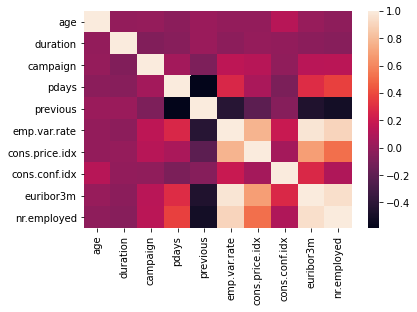

In [5]:
corr = data.corr()
figsize = (24,20)
sns.heatmap(corr)

## splitting and encoding the data

In [6]:
#X = data.drop('y', axis=1).copy()
#y = data.y.copy()
#sss = StratifiedKFold(n_splits=5,random_state=None,shuffle=False)
#for train_index, test_index in sss.split(X,y):
 #   print("Train:", train_index, "Test:", test_index)
 #   original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
  #  original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
#Check the Distribution of the labels


# Turn into an array
#original_Xtrain = original_Xtrain.values
#original_Xtest = original_Xtest.values
#original_ytrain = original_ytrain.values
#original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
#train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
#test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
#print('-' * 100)

#print('Label Distributions: \n')
#print(train_counts_label/ len(original_ytrain))
#print(test_counts_label/ len(original_ytest))

In [7]:
# splitting to X and y
X = data.drop(columns=['y','duration'], axis=1).copy()
encoder = LabelEncoder()
data['y'] = encoder.fit_transform(data["y"])
y = data.y
print(y.head())
# encoding the X data
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

# encode
encoder = OneHotEncoder(sparse=False)
X_encoded= pd.DataFrame(encoder.fit_transform(X[object_cols]))
X_encoded.columns = encoder.get_feature_names(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'])
X.drop(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'] ,axis=1, inplace=True)
dta= pd.concat([X, X_encoded ], axis=1)
dta.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int32
Categorical variables:
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Categorical variables:
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
# Scaling the data
cols = dta.columns
scaler = MinMaxScaler()
scaler.fit(dta)
X_scaled = pd.DataFrame(scaler.transform(dta),columns=[cols])
X_scaled.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.481481,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.493827,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.246914,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.283951,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.481481,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
## train test split to avoid leakage
from sklearn.model_selection import train_test_split,cross_val_score
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size = 0.1,random_state=1)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(37069, 62)
(37069,)
(4119, 62)
(4119,)


## Dimentionality reduction and clustering

In [11]:
#t0 = time.time()
#X_reduced_tsne = TSNE(n_jobs=4).fit_transform(X_train.values)
#t1 = time.time()
#print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=10).fit_transform(X_train.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD().fit_transform(X_scaled.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

PCA took 5.8 s
Truncated SVD took 4.8 s


In [12]:
X_reduced_pca.shape

(37069, 10)

# Class imbalance

In [13]:
data['y'].value_counts()
y_train.value_counts()

0    32934
1     4135
Name: y, dtype: int64

there is a huge imbalance in our dataset this might bring issues when creating our model.Lets see how we can solve this problem

## How to deal with imbalanced data

There are many different ways to deal with imbalanced data but we will focus on SMOTE

## Using SMOTE

In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

In [11]:
y_train_smote.value_counts()

1    32934
0    32934
Name: y, dtype: int64

Our data is now oversampled ratio btwn yes and no is the same

## Machine Learning Models

In [25]:
# Let's implement simple classifiers
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "MLP": MLPClassifier(early_stopping=True)
}

Model: LogisticRegression()
No handles with labels found to put in legend.
train score 0.7394181442964445
test score 0.8222869628550619
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      3614
           1       0.37      0.64      0.47       505

    accuracy                           0.82      4119
   macro avg       0.66      0.75      0.68      4119
weighted avg       0.87      0.82      0.84      4119

confusion matrix [[3062  552]
 [ 180  325]]
ROC 0.7454125047258462
LogisticRegression()  (area = 0.7)


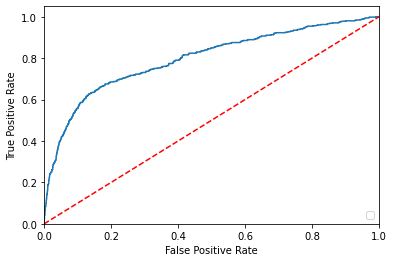

Model: RandomForestClassifier()
train score 0.9409737169929923
test score 0.8766690944403982
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3614
           1       0.50      0.35      0.41       505

    accuracy                           0.88      4119
   macro avg       0.70      0.65      0.67      4119
weighted avg       0.86      0.88      0.87      4119

confusion matrix [[3433  181]
 [ 327  178]]
ROC 0.6511961185050436
No handles with labels found to put in legend.
RandomForestClassifier()  (area = 0.7)


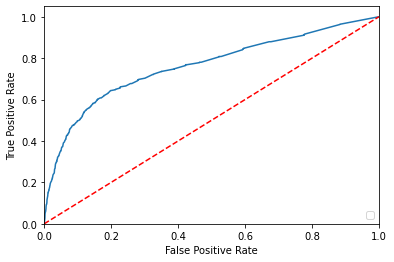

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
No handles with labels found to put in legend.
train score 0.9228777537669434
test score 0.8861374119932023
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3614
           1       0.57      0.30      0.39       505

    accuracy                           0.89      4119
   macro avg       0.74      0.64      0.67      4119
weighted avg       0.87      0.

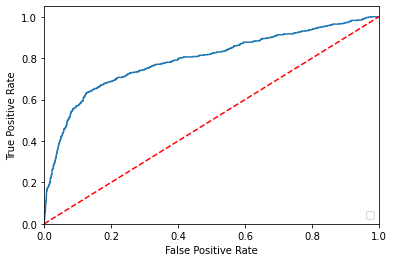

Model: DecisionTreeClassifier()
No handles with labels found to put in legend.
train score 0.9012883967972037
test score 0.8341830541393542
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      3614
           1       0.33      0.34      0.33       505

    accuracy                           0.83      4119
   macro avg       0.62      0.62      0.62      4119
weighted avg       0.84      0.83      0.84      4119

confusion matrix [[3265  349]
 [ 334  171]]
ROC 0.6210224813294833
DecisionTreeClassifier()  (area = 0.6)


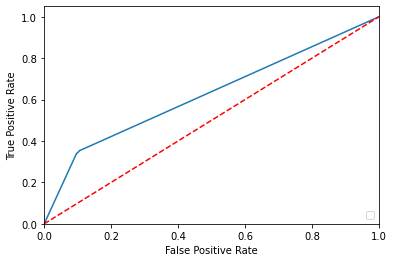

Model: MLPClassifier(early_stopping=True)
No handles with labels found to put in legend.
train score 0.8727310179233505
test score 0.8443797038116048
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3614
           1       0.38      0.44      0.41       505

    accuracy                           0.84      4119
   macro avg       0.65      0.67      0.66      4119
weighted avg       0.85      0.84      0.85      4119

confusion matrix [[3256  358]
 [ 283  222]]
ROC 0.6702723731144559
MLPClassifier(early_stopping=True)  (area = 0.7)


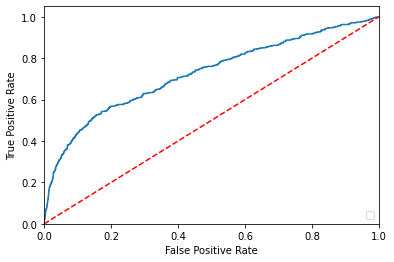

In [27]:
from sklearn.model_selection import cross_val_score
for key, classifier in classifiers.items():
    model = classifier
    model.fit(X_train_smote, y_train_smote)
    #training_score = cross_val_score(classifier, X_train_smote, y_train_smote, cv=5,n_jobs=-1)
    print('Model:',model)
    
    scores = cross_val_score(model,X_train_smote,y_train_smote,cv=5,n_jobs=-1)
    print('train score',scores.mean())
    print('test score',model.score(X_test,y_test))
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    confusio_matrix = confusion_matrix(y_test, y_pred)
    print('confusion matrix',confusio_matrix)

    # Ploting Roc
    import matplotlib.pyplot as plt

    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve
    roc_auc = roc_auc_score(y_test, y_pred)
    print("ROC",roc_auc)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    #print("fpr{}, tpr{}". format(fpr, tpr))
    header = print(model,' (area = %0.1f)' % roc_auc)

    plt.figure()
    plt.plot(fpr, tpr, label=header)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(header)
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [29]:
from sklearn.model_selection import cross_val_score
for key, classifier in classifiers.items():
    model = classifier
    model.fit(X_train_smote, y_train_smote)
    #training_score = cross_val_score(classifier, X_train_smote, y_train_smote, cv=5,n_jobs=-1)
    print('Model:',model)
    cv = StratifiedKFold(n_splits=5,random_state=0)
    scores = cross_val_score(model,X_train_smote,y_train_smote,cv=,n_jobs=-1)
    print('train score',scores.mean())
    print('test score',model.score(X_test,y_test))
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    confusio_matrix = confusion_matrix(y_test, y_pred)
    print('confusion matrix',confusio_matrix)

    # Ploting Roc
    import matplotlib.pyplot as plt

    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve
    roc_auc = roc_auc_score(y_test, y_pred)
    print("ROC",roc_auc)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    #print("fpr{}, tpr{}". format(fpr, tpr))
    header = print(model,' (area = %0.1f)' % roc_auc)

    plt.figure()
    plt.plot(fpr, tpr, label=header)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(header)
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

Model: LogisticRegression()


TypeError: cross_val_score() missing 1 required positional argument: 'X'

## tuning

In [25]:
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [1.0,1.5,2.0,2.5]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)
random = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv = 3, n_jobs=-1)

start_time = time.time()
random_result = random.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.901481 using {'max_iter': 130, 'dual': False, 'C': 1.0}
Execution time: 9.27051067352295 ms


In [34]:
confusion_matrix

array([[3513,  101],
       [ 365,  140]], dtype=int64)

**Intepretating Confusion Matrix**


|  | Predicted: No | Predicted Yes |
| --- | --- | --- |
| Actual No |TN: 3521  | FP: 93 |
|  |  |  |
| Actual Yes |FN: 296  | TP: 209 |

1. Correct predictions: 3521 + 93 = 3614

2. Wrong Predictions: 296+209 = 505
  

#### Roc curve

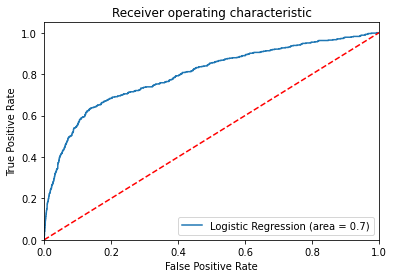

In [23]:
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
#print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
#print("fpr{}, tpr{}". format(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.1f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [28]:
from sklearn.model_selection import RandomizedSearchCV
learning_rate = [0.1,0.05,0.01]
max_depth = [3,5,10,]
subsample = [0.8,0.9,1]
colsample_bytree= [0.3,0.5,0.8]
param_grid = dict(learning_rate=learning_rate,max_depth=max_depth,subsample=subsample,colsample_bytree=colsample_bytree)
random = RandomizedSearchCV(estimator=XGBClassifier(), param_distributions=param_grid, cv = 3, n_jobs=-1)

start_time = time.time()
random_result = random.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.902398 using {'subsample': 0.8, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Execution time: 59.08179187774658 ms


In [25]:
pipe = Pipeline([("classifier",XGBClassifier())])
grid_param = [{"classifier":[XGBClassifier()],
"classifier__learningrate" : [0.1,0.05],
"classifier__maxdepth" : [3,5,10,],
"classifier__subsample" : [0.8,0.9,1],
"classifier__colsamplebytree" : [0.3,0.5,0.8]
},
{"classifier":[LogisticRegression()],
'classifier__C' : np.logspace(-4, 4, 10),
'classifier__solver' : ['liblinear']
},
{"classifier":[SVC(verbose=True)],
"classifier__kernel":['linear', 'rbf', 'poly'],
"classifier__gamma":[0.1,1,10,100],
"classifier__C":[0.1,1,10,100]
},
    {"classifier":[MLPClassifier(early_stopping=True)],
    "classifier__max_iter":[100,200],
    'classifier__alpha': [0.0001, 0.05],
    }
]

random_search = RandomizedSearchCV(pipe,grid_param,cv=5,verbose=3,n_jobs=-1)

In [26]:
mod = random_search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 19.7min finished


In [31]:
print(mod.best_params_)
#print(mod.score(X_train,y_train))

{'classifier__solver': 'liblinear', 'classifier__C': 2.782559402207126, 'classifier': LogisticRegression(C=2.782559402207126, solver='liblinear')}


## Stratified Kfold

In [ ]:
model1 = LogisticRegression()
model2 = XGBClassifier()
model3 = SVC()
model4 = MLPClassifier()
pipeline_lr = Pipeline([('scaler',StandardScaler()),('pca',PCA(n_components=10)),('classifier',model1)])
pipeline_xgb = Pipeline([('scaler1',StandardScaler()),('pca1',PCA(n_components=10)),('classifier1',model2)])
pipeline_svm = Pipeline([('scaler2',StandardScaler()),('pca2',PCA(n_components=10)),('classifier2',model3)])
pipeline_mlp = Pipeline([('scaler3',StandardScaler()),('pca3',PCA(n_components=10)),('classifier3',model4)])
pipelines = [pipeline_lr,pipeline_xgb,pipeline_svm,pipeline_mlp]

In [121]:
cv =StratifiedKFold(n_splits=5,random_state=0)
pipe_dict = {0: 'Lr',1:'xgb',2:'svm',3:'mlp'}
for i,model in enumerate(pipelines):
    #print('{} Test accuracy',format(pipe_dict[i],
    #model.score(X_train,y_train)))
    print('Model:',pipe_dict[i])
    scores = cross_val_score(model,X_train,y_train,cv=cv)
    print('train score',scores.mean())
    print('test score',model.score(X_test,y_test))

Model: Lr
train score 0.89740753190203
test score 0.8871085214857976
Model: xgb
train score 0.894413175026149
test score 0.883709638261714
Model: svm
train score 0.8996465828536844
test score 0.8890507404709881
Model: mlp
train score 0.8967061160973451
test score 0.8858946346200534


In [131]:
cv =5
pipe_dict = {0: 'Lr',1:'xgb',2:'svm',3:'mlp'}
for i,model in enumerate(pipelines):
    #print('{} Test accuracy',format(pipe_dict[i],
    #model.score(X_train,y_train)))
    print('Model:',pipe_dict[i])
    model.fit(X_train, y_train)
    scores = cross_val_score(model,X_train_smote,y_train_smote,cv=cv)
    print('train score',scores.mean())
    print('test score',model.score(X_test,y_test))
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    confusio_matrix = confusion_matrix(y_test, y_pred)
    print('confusion matrix',confusio_matrix)

Model: Lr
train score 0.7148994132813563
test score 0.8871085214857976
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      3614
           1       0.66      0.16      0.26       505

    accuracy                           0.89      4119
   macro avg       0.78      0.58      0.60      4119
weighted avg       0.87      0.89      0.86      4119

confusion matrix [[3572   42]
 [ 423   82]]
Model: xgb
train score 0.7765683278881104
test score 0.8805535324107793
              precision    recall  f1-score   support

           0       0.90      0.98      0.93      3614
           1       0.53      0.20      0.29       505

    accuracy                           0.88      4119
   macro avg       0.72      0.59      0.61      4119
weighted avg       0.85      0.88      0.86      4119

confusion matrix [[3526   88]
 [ 404  101]]
Model: svm
train score 0.7418473083108577
test score 0.8888079630978393
              precision    recall  f1-score

**Intepretating Confusion Matrix**
Linear regression

|  | Actual: No | Actual Yes |
| --- | --- | --- |
| Predicted No |TP: 3572  | FP: 42 |
|  |  |  |
| Predicted Yes |FN: 432  | TN: 73 |

1. Correct predictions: 3572 + 73 = 3645

2. Wrong Predictions: 432+73 = 505

Xgboost

|  | Actual: No | Actual Yes |
| --- | --- | --- |
| Predicted No |TP: 3547  | FP: 67 |
|  |  |  |
| Predicted Yes |FN: 409  | TN: 96 |

1. Correct predictions: 3547 + 96 = 3643

2. Wrong Predictions: 409+67 = 476

svm

|  | Actual: No | Actual Yes |
| --- | --- | --- |
| Predicted No |TP: 3574  | FP: 40 |
|  |  |  |
| Predicted Yes |FN: 414  | TN: 91 |

1. Correct predictions: 3574 + 91 = 3665

2. Wrong Predictions: 414+40 = 454

MLP

|  | Actual: No | Actual Yes |
| --- | --- | --- |
| Predicted No |TP: 3547  | FP: 67 |
|  |  |  |
| Predicted Yes |FN: 391  | TN: 114 |

1. Correct predictions: 3547 + 67 = 3614

2. Wrong Predictions: 391+114 = 505

In [33]:
##After tuning

In [34]:
model = LogisticRegression(C=3, solver='liblinear')
model.fit(X_train,y_train)

LogisticRegression(C=3, solver='liblinear')

In [38]:
y_pred_tuned=model.predict(X_test)
print(classification_report(y_test, y_pred_tuned))
confusio_matrix = confusion_matrix(y_test, y_pred_tuned)
print('confusion matrix',confusio_matrix)

precision    recall  f1-score   support

           0       0.90      0.98      0.94      3614
           1       0.66      0.22      0.33       505

    accuracy                           0.89      4119
   macro avg       0.78      0.60      0.63      4119
weighted avg       0.87      0.89      0.86      4119

confusion matrix [[3558   56]
 [ 396  109]]


In [ ]:
def modelKfold(model, x,y,X_train):
logReg=LogisticRegression()
mlp=MLPClassifier()
dectree=DecisionTreeClassifier()
scores=[]
cv=KFold(n_splits=5, random_state=42,shuffle=True)
for trainIndex, testIndex in cv.split(X_train):
cvX_train, cvX_test=x.iloc[trainIndex], x.iloc[testIndex]
cvy_train, cvy_test=y.iloc[trainIndex], y.iloc[testIndex]
modelTrained=model.fit(cvX_train,cvy_train)
ypred=modelTrained.predict(x.iloc[testIndex])
scores.append(accuracy_score